# Clear Day Detection

This notebook illustrates how the `DataHandler` class automatically segments PV power data in to "clear" days and "cloudy" days. The algorithm estimates the clear days in a data set two ways and then combines the estimates for the final estimations. The first estimate is based on the "smoothness" of each daily power signal. The second estimate is based on the seasonally adjusted daily energy output of the system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from solardatatools import DataHandler, get_pvdaq_data

Use the supplied helper function to grab data from NREL's [PVDAQ](https://developer.nrel.gov/docs/solar/pvdaq-v3/) service.

In [2]:
df = get_pvdaq_data(sysid=35, api_key='DEMO_KEY', year=[2011, 2012, 2013])

[============================================================] 100.0% ...queries complete in 5.0 seconds       



In [3]:
df.head()

,SiteID,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inv1_ac_power,inverter_airtemp,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
2011-01-01 00:00:00,35.0,0.0,-200.0,284.0,-3.353332,-3.0,-200.0,18.0,NaN,NaN,0.0,25.0,-7.105555,0.0,0.0,53.513,315.270,0.483250
2011-01-01 00:15:00,35.0,0.0,-200.0,284.0,-3.381110,-4.0,-200.0,18.0,NaN,NaN,0.0,25.0,-6.944444,0.0,0.0,53.581,308.835,0.698724
2011-01-01 00:30:00,35.0,0.0,-300.0,284.0,-3.257777,-3.0,0.0,17.0,NaN,NaN,0.0,25.0,-6.344444,0.0,0.0,53.413,272.678,0.218156
2011-01-01 00:45:00,35.0,0.0,-300.0,284.0,-3.296666,-3.0,-200.0,17.0,NaN,NaN,0.0,24.0,-6.655555,0.0,0.0,52.406,55.913,0.159146
2011-01-01 01:00:00,35.0,0.0,-300.0,284.0,-3.426110,-3.0,-200.0,16.0,NaN,NaN,0.0,24.0,-7.405555,0.0,0.0,53.588,152.145,0.240508


Pass the tabular data in the data frame to the `DataHandler` object instance, and run the pipeline on the desired column.

In [4]:
dh = DataHandler(df)

In [5]:
dh.keys

['SiteID',
 'ac_current',
 'ac_power',
 'ac_voltage',
 'ambient_temp',
 'dc_current',
 'dc_power',
 'dc_voltage',
 'inv1_ac_power',
 'inverter_airtemp',
 'inverter_error_code',
 'inverter_temp',
 'module_temp',
 'poa_irradiance',
 'power_factor',
 'relative_humidity',
 'wind_direction',
 'wind_speed']

In [6]:
dh.run_pipeline(power_col='dc_power')

d:\0_cmu_coursework\practicum\profiling\solar-data-tools\solardatatools\time_axis_manipulation.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[0] >= thresh:
d:\0_cmu_coursework\practicum\profiling\solar-data-tools\solardatatools\time_axis_manipulation.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[-1] >= thresh:


clipping check failed: Unable to allocate 4.66 GiB for an array with shape (24998, 24998) and data type float64


Traceback (most recent call last):
  File "d:\0_cmu_coursework\practicum\profiling\solar-data-tools\solardatatools\data_handler.py", line 375, in run_pipeline
    self.clipping_check(solver=solver_convex)
  File "d:\0_cmu_coursework\practicum\profiling\solar-data-tools\solardatatools\data_handler.py", line 868, in clipping_check
    self.clipping_analysis.check_clipping(
  File "d:\0_cmu_coursework\practicum\profiling\solar-data-tools\solardatatools\algorithms\clipping.py", line 75, in check_clipping
    self.pointmass_detection(
  File "d:\0_cmu_coursework\practicum\profiling\solar-data-tools\solardatatools\algorithms\clipping.py", line 139, in pointmass_detection
    self.get_l2_l1d2(y_rs, weight=weight, solver=solver)
  File "d:\0_cmu_coursework\practicum\profiling\solar-data-tools\solardatatools\algorithms\clipping.py", line 373, in get_l2_l1d2
    out = l2_l1d2_constrained(y, w1=weight, solver=solver)
  File "d:\0_cmu_coursework\practicum\profiling\solar-data-tools\solardatatools\

total time: 35.59 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              24.38s
Cleaning                   2.10s
Filtering/Summarizing      9.12s
    Data quality           0.58s
    Clear day detect       4.39s
    Clipping detect        0.05s
    Capacity change detect 4.09s



The standard pipeline include the clear day detection. We can inspect the results using supplied plotting functions. Here we look at the total daily energy and mark the days that are identified as clear.

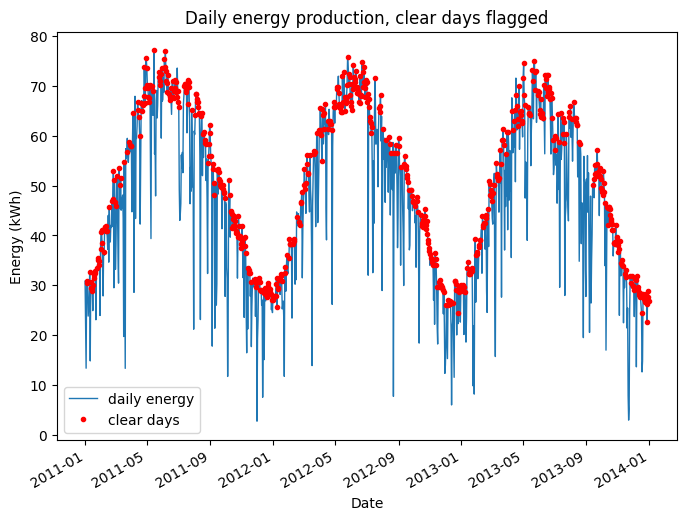

In [7]:
dh.plot_daily_energy(flag='clear')
plt.legend(['daily energy', 'clear days']);

We use a boolean index to mark the clear days. Each `True` entry corresponds with a day that is detected as clear. You can access it as an attribute under `daily_flags`:

In [8]:
dh.daily_flags.clear

array([False, False, False, ...,  True,  True,  True])